<h1><a id="Contents">Contents</a></h1>

[Overview](#Overview)  
[Working environment](#WE)
- [Python setup](#pyset)

[Making maps out of flower photos](#digitize)
 - [Getting images out of Doug's raster pipeline](#dougOut)
 - [Digitizing petal outlines](#skimmage)
   
 - [Calling center, edge and throat zones](#callZones)
 - [Applying our digitizing and Zone-calling to all files](#applyDigZone)
 - [Side note: Geojson files equal freedom!](#geoJFree)
 - [Manual correction of spots and zones](#manCor)  

[Measuring raw data](#zones)
  - [Some nuts and bolts - how are traits measured](#NutsNBolts)
  - [Traits overview](#TraitOverview)
  
[Updating PyPi](#updatePyPi)
 

<h1><a id="Overview">Overview</a></h1>

In general, converting photographic images to vector images in order to answer biological questions requires at least three steps: 

1. [Making maps](#digitize): process the image into a schematic of the image that recognizes and retains the parts of the photo that are informational.

2. [Measuring raw data from from this map](#zones): calling zones, counting spots, etc.

3. Statistical analyses on these data

All three of these steps require a lot of decision-making and coding. What follows is a review of the path we've taken to get to statistical analysis for our images.   

If the progamming code is confusing to read at any point, skip it. Read the human-language stuff. 

<h1><a id="WE">Working environment</a></h1>

Due to the history of the project, the first bit of code below is for matlab/octave. After that, we'll use mostly BASH and python(>3.6). The custom modules used here, contained in the makeFlowerPolygons package, are written for unix-like environments, so windows won't work at this point, but MacOS and linux systems should be compatible.

To start, clone the github repo at <https://github.com/danchurch/mimulusSpeckling.git>. If you don't already have git on your computer, I would recommend it for this project.

`git clone https://github.com/danchurch/mimulusSpeckling.git`

I will try to remember to make all paths used below relative to the main directory of the is repo, which is called "mimulusSpeckling".

After this install the custom modules we use to phenotype our flowers, in the package "makeFlowerPolygons". It is available in pypi, install it using pip, something like:

`pip3 install makeFlowerPolygons-dcthom`

You may want superuser privileges for that:

`sudo pip3 install makeFlowerPolygons-dcthom`

You may find that you are missing some dependencies for the modules, you'll have to install them as they come up. Apologies, in the future if I have time I'll define the requirements in the setup files.

You may find it useful to make a shortcut to your repo directory. I put this in my `~/.bashrc` (linux) or `~/.bash_profile` for mac OS.

In [2]:
alias speck="cd /home/daniel/Documents/cooley_lab/mimulusSpeckling"

<h3><a id='pyset'>Python setup</a></h3>

We do a lot of this work in python. Here is what you need when in the python environment:

In [3]:
import os, pickle, sys
## have to do makeFlower import before our matplotlib import, 
## because makeFlowerPolygons sets the proper backend for matplotlib:
from makeFlowerPolygons import flowerPetal, geojsonIO
## but if we want to use tkagg inside the notebook, we have to do this?:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import shapely.geometry as sg
import shapely.affinity as sa
import matplotlib.image as mpimg
from skimage import measure
from descartes import PolygonPatch
from scipy.spatial import distance

Make sure that you're in the home directory of the repo. This will vary depending on where you put it, of course, but mine looks like this:

In [8]:
os.chdir("/home/daniel/Documents/cooley_lab/mimulusSpeckling")

<h1><a id="digitize">Making maps out of flower photos</a></h1>

<a id='dougOut'><h3>Getting images out of Doug's raster pipeline</h3></a>

Flower photos were broken into their various petals of interest, and color differences were categorized, by forcing all pixels into three color poles using kmeans clustering. Doug coded this pipeline, and Melia implemented it, also doing manual corrections where needed. A "bottom" petal, for instance looks like this, after Doug's pipeline (converted to grayscale):

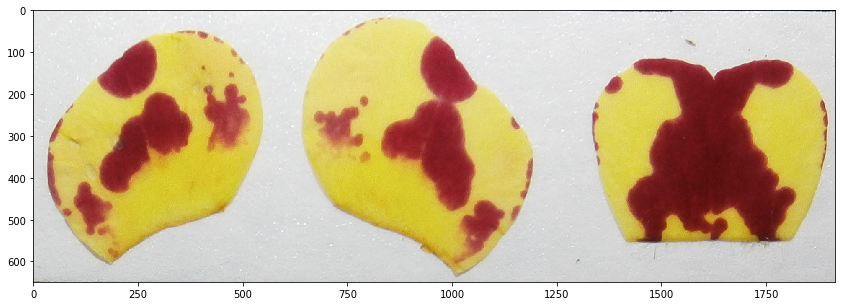

In [9]:
## stay in python for a sec, before we go to matlab/octave
exFlowerImage="dougRaster/Rotated_and_Cropped/plate1/P431F1.JPG"

plt.rcParams['figure.figsize'] = [15, 5]

img=mpimg.imread(exFlowerImage)
plt.imshow(img)

In <b>matlab or octave</b>, we can see how Doug's pipeline sees these petals:

In [13]:
octave --no-gui

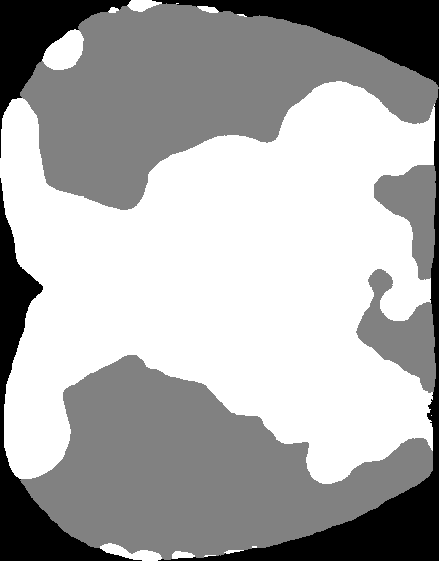

In [1]:
load("dougRaster/Rotated_and_Cropped/plate1/P431F1.mat")
pkg load image
aa = mat2gray(Petals.Clusters.right);
imshow(aa) %% that works.

We want to make polygons of spots and their petals. We can begin by "peeling" these two apart into separate, solid-black images:

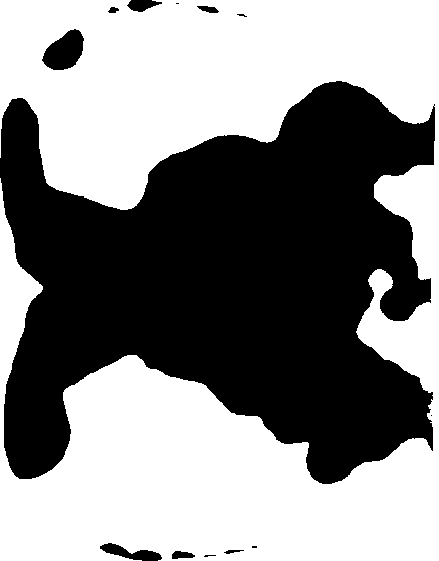

In [2]:
bb = aa < 1;
imshow(bb);


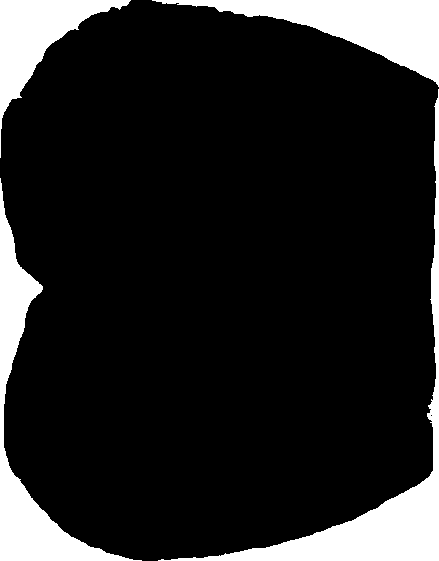

In [3]:
cc = aa == 0;
imshow(cc);

We can generalize the above process, to get all of the available photos from Doug's efforts into a form ready to digitized. All of our image processing was originally done in chunks, named by the plates in which flower DNA was placed and thus data was outputted from the sequencers. This is code for plate 4 for instance: 

In [ ]:
wd='/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/polygons/plate4'

dougRasterDir='/home/daniel/Documents/cooley_lab/mimulusSpeckling/dougRaster/Rotated_and_Cropped/plate4'

cd(dougRasterDir)

files = dir('P*.mat');

for file = files';
    im = file.name;
    imName = regexprep(im,'\.mat', ''); 
    %% go get our file, come back
    cd(dougRasterDir);
    rast=load(im);
    cd(wd);
    %% make a spot for our image, go to it:
    mkdir(imName);
    cd (imName);
    %% get our petal names (left, right mid)
    petNames = fieldnames(rast.Petals.Clusters);
    %% split images into petal and spot, export, for each of the three petals:
    for i = 1:length(petNames);
        pet = rast.Petals.(petNames{i}).data; %petal at hand
        mkdir(petNames{i});
        cd(petNames{i});
        %% for octave
        fileNamePetal = [imName "_" char(petNames(i)) "_" 'melted.csv'];
        %% for matlab, this may work better?
        %%fileNamePetal = imName + "_" +  petNames(i) + "_" + 'melted.csv';
        csvwrite(fileNamePetal,pet);
        cd ..;
    end;


(This is brittle code, if the file architectures or Doug's matlab structures changes, it will break. But for the moment it works. And it gets us out of matlab real quick-like.)

It is important to note what is going on here, because this may be one of the more universal entry points in to the pipeline. At this step, we are going into the matlab objects that are created by Doug's color simplification process. These are stored as matlab-type ".mat" files, in the following directory of our repo, in doug's folder, by plate. The jpg images in this folder are also stored here:

In [9]:
ls dougRaster/Rotated_and_Cropped

plate1  plate2  plate3  plate3Additional  plate4  plate4Additional


In [10]:
ls dougRaster/Rotated_and_Cropped/plate3

P773F1.JPG  P788F2.JPG  P814F3.JPG  P828F1.JPG  P842F1.JPG  P861F1.JPG
P773F1.mat  P788F2.mat  P814F3.mat  P828F1.mat  P842F1.mat  P861F1.mat
P773F2.JPG  P789F1.JPG  P815F2.JPG  P828F2.JPG  P842F2.JPG  P862F1.JPG
P773F2.mat  P789F1.mat  P815F2.mat  P828F2.mat  P842F2.mat  P862F2.JPG
P774F2.JPG  P789F2.JPG  P815F3.JPG  P829F1.JPG  P843F1.JPG  P863F1.JPG
P774F2.mat  P789F2.mat  P815F3.mat  P829F1.mat  P843F1.mat  P863F1.mat
P774F3.JPG  P791F1.JPG  P816F1.JPG  P829F2.JPG  P843F2.JPG  P863F2.JPG
P774F3.mat  P791F1.mat  P816F1.mat  P829F2.mat  P843F2.mat  P863F2.mat
P775F2.JPG  P791F2.JPG  P816F2.JPG  P830F1.JPG  P844F1.JPG  P864F1.JPG
P775F2.mat  P791F2.mat  P816F2.mat  P830F1.mat  P844F1.mat  P864F2.JPG
P775F3.JPG  P792F4.JPG  P817F1.JPG  P830F2.JPG  P844F2.JPG  P865F1.JPG
P775F3.mat  P792F4.mat  P817F1.mat  P830F2.mat  P844F2.mat  P865F1.mat
P776F1.JPG  P793F1.JPG  P817F2.JPG  P831F1.JPG  P845F1.JPG  P865F2.JPG
P776F1.mat  P793F1.mat  P817F2.mat  P831F1.mat  P845F1.mat  P865F2.mat
P776F2

In the matlab/octave script above we grab a particular component of these matlab object files, a matrix that contains the pixel color and location info, and export it as a csv. Each petal is labeled by Doug by the order they appear on the photos: "left", "mid", and "right". These names have nothing to do with the position of the petals on the flowers.

The script above then makes a directory for each flower, then subdirectories for each petal, where the CSV files are placed. Later, we will also store our geojson files here, see [below](#geoJFree). The file names for these new CSVs are:

`[Plant-number] + [Flower-number] + "_" + [left/mid/right] + "_melted.csv"`

For instance: `P773F1_left_melted.csv`

Each of these matrix-turned-CSVs have four columns, and a row for each pixel. There is no header for these files, so here is an explanation:

<ul>
<li>The first and second columns are X and Y coordinates. </li>
<li>The third column cells should all contain the same value, either all 1, 2, or 3. 1 is a 'left' petal, 2 is a 'mid' petal, and 3 is a 'right' petal.  </li>
<li>The fourth column contains the color information. Doug's formatting only retains non-background (non-white-tape) pixels. 2 indicates petal color, 3 is spot color. Thus this column should contain only 2's and 3's. </li>
</ul>

Looking at a few lines of one of these files:

In [3]:
sed -n '4310,4320'p make_polygons/polygons/plate3/P773F1/left/P773F1_left_melted.csv

120,631,1,2
120,632,1,2
120,633,1,2
120,634,1,2
120,635,1,2
120,636,1,2
120,637,1,3
120,638,1,3
120,639,1,3
120,640,1,3
120,641,1,3


This is showing pixels with an X of 120, a y-positions from 631 to 641. In the third column, we can see this is a 1='left' petal, and in the fourth column we see some pixels are petal ('2') and some are spots ('3'). 

<h3> Some notes for future development </h3>

These pixel position data get inverted often because coordinate systems vary in their origins when dealing with pixels and rasters. Raster/graphical coordinate systems often have the origin in the upperleft corner and increase in number as they go down the screen, we'll see that this flips the images when we go from viewing our petals as a raster to viewing their polygons in pyplot. I tried not to worry about these inversions too much, and did not mess with the original x, y positions at each step, just to try to retain the integrity of the data as much as possible. This means, however, that we end up looking at and working with upsidedown images quite often.

Perhaps more important here is that if this place is to be used as a starting point for image inputs to our pipeline, we may want to simplify here for others' ease of use. This pipeline is written specifically to deal with the quirks of the outputs from Doug's matlab scripts (2 and 3 for colors, no 1's, an unnecessary third column, etc etc.). If other labs were to use this, they would probably find these requirements annoying, 

<a id='skimmage'><h2>Digitizing petal outlines</h2></a>

Now we create map-like features out of our images, a process in GIS known as digitizing. We'll be using our custom python package for this project, `flowerPetal`, which can be found at https://pypi.org/project/makeFlowerPolygons-dcthom/. The github repo for this package is currently <a href="https://github.com/danchurch/mimulusSpeckling/tree/master/make_polygons"> here </a>. `flowerPetal` is built mostly using tools from [scikit-image](https://scikit-image.org/), and [shapely](toblerity.org/shapely/manual.html). These are among the standard packages for manipulating images and polygons in python. We'll also import the other packages as necessary for this analysis. 

<h5><a id='parseDoug'>Calling spots and petals from images</a></h5>

Above we dug into Doug's matlab pipeline, and extracted the data we needed from his matlab data objects into a more universal format, a CSV. As our next step, we need find our petals and spots in these CSVs, and put their information into a format that is useful to us. The module `get_spots` of our `makeFlowerPolygons` package tries to do this. 

As an example, we'll assemble a toy directory with a few flowers images in it, and run our modules as scripts on these:

In [9]:
toy=$PWD"/make_polygons/toy"
mkdir $toy
newSpots=$toy"/newSpots"
mkdir $newSpots

Get some sample CSVs to play with:

In [10]:
cp -r ./make_polygons/polygons/plate3/P77{3,4}* $toy

Just for continuity, I'm also going to bring in this CSV, which is from one of the petals that we looked at [above](#dougOut). It's an image from  plate 1. Plate 1 and 2 geojsons and CSVs are in our google drive of finished images, to keep the repo from being so bloated. I've put a copy back in the repo:

In [11]:
mkdir -p $toy/P431F1/right
cp ./make_polygons/notebooks/P431F1_right_melted.csv $toy/P431F1/right

Our modules are available to be used as scripts in the repo itself. The `get_spots` module is here:

In [12]:
get_spots='make_polygons/package/makeFlowerPolygons/get_spots.py'

The `get_spots` module acts on a single CSV file at a time, in the format mention above from Doug's pipeline. For one petal csv file at a time, the syntax for the `get_spots` script is:

In [13]:
$get_spots -h

usage: get_spots.py [-h] [--destination DESTINATION] [--skipFinalClean] file

positional arguments:
  file                  Name of file that contains CSV versions of doug's
                        "melted" matrix, the result of manually choosing color
                        centers from his matlab color-categorization scripts.

optional arguments:
  -h, --help            show this help message and exit
  --destination DESTINATION, -d DESTINATION
                        Folder where you would like the outputted geojson.
                        Default is same directory.
  --skipFinalClean, -s  Use this flag to skip the clean step that occasionally
                        disappears polygons, if it can't fix them any other
                        way.


The last optional argument, `--skipFinalClean`, is necessary sometimes because our spot "cleaning" process, which attempts to resolve invalidities in the polygons, also sometimes deletes entire spots when it cannot resolve the errors in them any other way. When this happens, it's sometimes useful to retain the invalid polygon and fix it manually, with QGIS or with a text editor. 

Another developer issue here is that error logging for polygon calls from images is really bad right now. There should be better tracking of which polygons worked, which ones needed fixing, which ones were thrown out, etc. 

We'll get the list of the CSVs and run the script on each:

In [14]:
csvs=$(find $toy -name "*_melted.csv") 

for i in ${csvs[@]}; do
    echo $i
    $get_spots $i -d $newSpots 
done

/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/toy/P774F2/mid/P774F2_mid_melted.csv
P774F2_mid_polys
P774F2_mid_polys petal is invalid! Opening bag of tricks
Trying buffering
Buffering complete. P774F2_mid_polys petal seems better.
This spot multipolygon seems okay without buffering.
/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/toy/P774F2/left/P774F2_left_melted.csv
P774F2_left_polys
P774F2_left_polys petal is invalid! Opening bag of tricks
Trying buffering
Buffering complete. P774F2_left_polys petal seems better.
This spot multipolygon seems okay without buffering.
/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/toy/P774F2/right/P774F2_right_melted.csv
P774F2_right_polys
This spot multipolygon seems okay without buffering.
/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/toy/P774F3/mid/P774F3_mid_melted.csv
P774F3_mid_polys
This spot multipolygon seems okay without buffering.
/home/daniel/Documents/cooley_lab/mimul

Using matplotlib (<b>so back to python</b>), we can see the original image:

In [1]:
exFlowerImage="./dougRaster/Rotated_and_Cropped/plate1/P431F1.JPG"

<IPython.core.display.Javascript object>


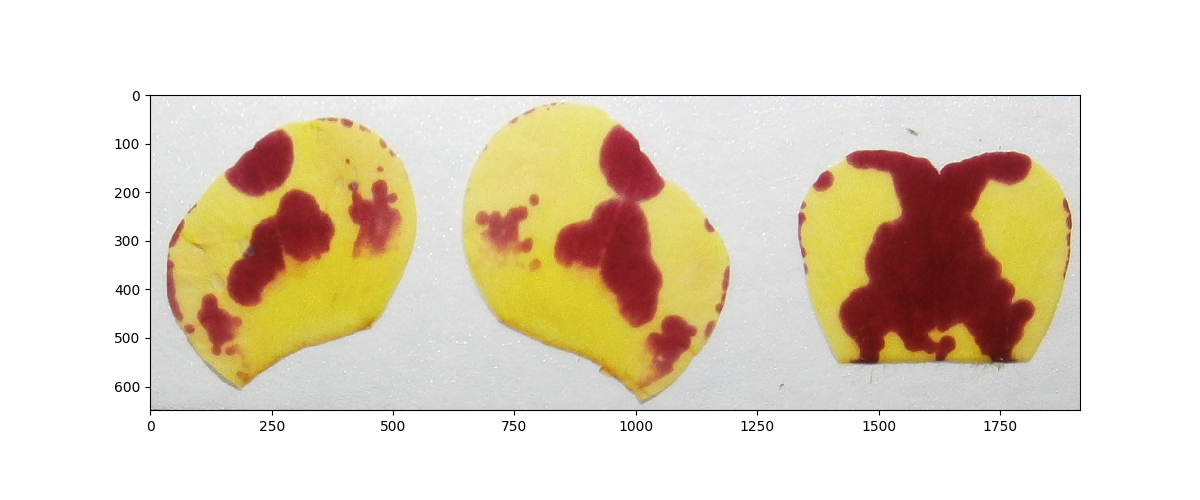

In [5]:
plt.rcParams['figure.figsize'] = [12, 5]
img=mpimg.imread(exFlowerImage)
plt.imshow(img)

After applying the above digitizing functions, we get petals with an area of 1, centered at 0,0 : 

<IPython.core.display.Javascript object>


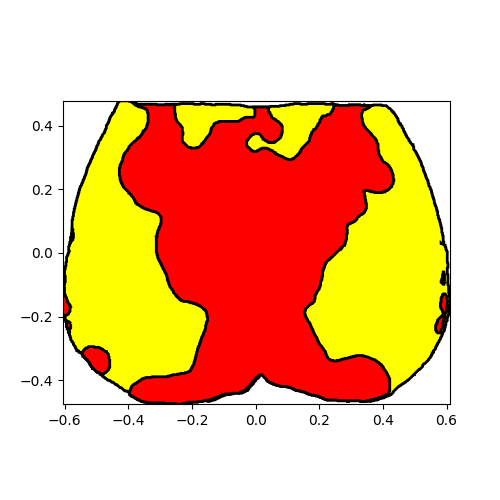

([<matplotlib.patches.PathPatch at 0x7fbc142d0b38>,
 [None, None, None, None, None, None, None, None])

In [12]:

plt.rcParams['figure.figsize'] = [5, 5]
exPol=geojsonIO.parseGeoJson("make_polygons/toy/newSpots/P431F1_right_polys.geojson")

geojsonIO.plotOne(exPol[0]); geojsonIO.addOne(exPol[1])

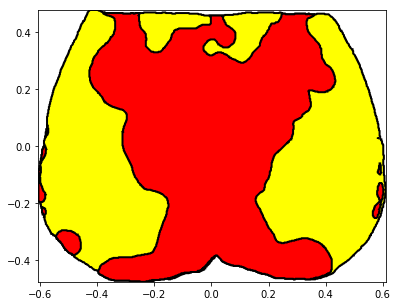

In [29]:
exPol=geojsonIO.parseGeoJson("/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/geojsons_working/P431F1_right_polys.geojson")

geojsonIO.plotOne(exPol[0]); geojsonIO.addOne(exPol[1])

<h3><a id="callZones">Calling center, edge and throat zones</a></h3>

We'll define three zones of interest - center, margin and petal. In another module, "[get_zones.py](https://raw.githubusercontent.com/danchurch/mimulusSpeckling/master/make_polygons/get_zones.py)", we define the proportion ('percent') of petal we would like to remain as "center", and the rest is given to the margin and throat. 

This is done using two functions. To call an internal "Center" zone that is 50% (the default setting) of the petal area, we iteratively grow a margin inside the petal polygon until the remaining center approximates 50%:

In [31]:
def findCenter(standPol, percent):
    ## generate margin/center
    center = standPol
    rad = 0
    while center.area > percent:
        center = standPol.buffer(rad)
        rad -= .001
    cent = sg.polygon.Polygon(center.exterior.coords)
    return(cent)

Finding the throat is trickier. Without developing some smarter computer vision, our best landmarks are the corners on these petals from the cuts with which they were originally separated. We try to find these using the "[simplify](#https://shapely.readthedocs.io/en/stable/manual.html#other-operations)" function from shapely, which reduces the number of vertices in a polygon:

In [ ]:
def findEdgeThroat(petal, center, simp=0.5):
    #simp=0.5
    ## generate margin/center
    petal = cleanPoly(petal)
    center = cleanPoly(center)
    marg = sg.polygon.Polygon(
            petal.exterior,
            holes = [center.exterior.coords])
    ## break up margin into edge and throat:
    simPol = marg.simplify(simp)
    ## get array of x,y coords separated
    simPolA = np.array(simPol.exterior.xy).transpose()
    ## sort by y coords:
    simPolAsorted = simPolA[simPolA[:,1].argsort()[::-1]]
    leftSide=simPolAsorted[simPolAsorted[:,0] < 0]
    upperleft=leftSide[0,:]
    rightSide=simPolAsorted[simPolAsorted[:,0] > 0]
    upperright=rightSide[0,:]
    simPolB = np.array(simPol.interiors[0].xy).transpose()
    simPolBsorted = simPolB[simPolB[:,1].argsort()[::-1]]
    leftSide=simPolBsorted[simPolBsorted[:,0] < 0]
    lowerleft=leftSide[0,:]
    rightSide=simPolBsorted[simPolBsorted[:,0] > 0]
    lowerright=rightSide[0,:]
    corners = np.stack((upperleft, upperright,lowerright,lowerleft))
    tRapPoly = cleanPoly(sg.polygon.Polygon(corners))
    try:
        tBuff = tRapPoly.buffer(0.1)
        tBuff = cleanPoly(tBuff)
        noTrap = marg.difference(tRapPoly)
        notInTrap = [ i for i in noTrap if i.within(tBuff) ]
        mpNotInTrap = sg.multipolygon.MultiPolygon(notInTrap)
        margInTrap = tRapPoly.intersection(marg)
        throatRaw = margInTrap.union(mpNotInTrap )
        throat = cleanCollections(throatRaw)
        edgeRaw = marg.difference(throat)
        edge = cleanCollections(edgeRaw)
    except:
        print ("Zones failed...")
        edge, throat = None, None
    finally:
        return(edge, throat)


There is a lot going on in that function. Some helper functions try to clean up small junk geometries created by our petal/spot digitizing and our throat/edge separation. These are then given to the center-finding algortithm. Following this, separation of margin into edge and throat are done, dependent on the simplification method of polygons in shapely mentioned above. Using this we harden the lines of the polygon according to the "simp" parameter of the function. This results in fewer vertices and we pick the top two vertices in our petal outline and in our margin to delineate the four corners of the throat. This works as a first guess but fails often for finding the throat/edge. So downstream we have built in a manual correction/sanity check into this pipeline. 

With these functions, we can take the petal and spots from doug's rasters and make some standardized petal and spot polygons:

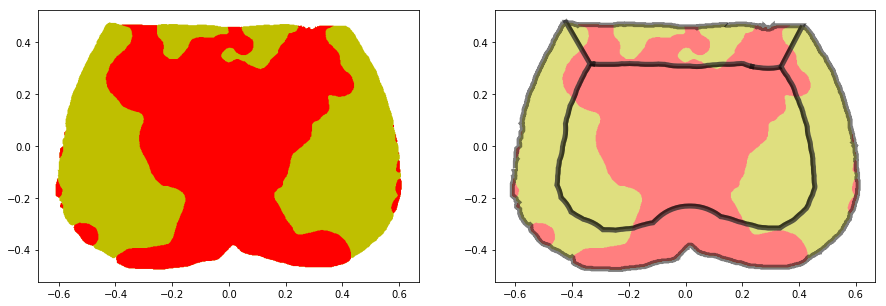

In [16]:
pZones(standPet, spotz, center, edge, throat)

We have a petal area = 1, and petal centroid is on the origin. Zones are coming along. Generally, looks good. But how about our upper petals (doug's "left" and "mid" petals)?

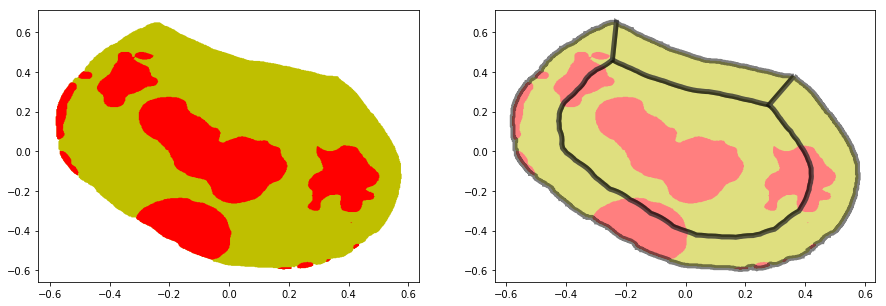

In [20]:
pZones(standPet, spotz, center, edge, throat)

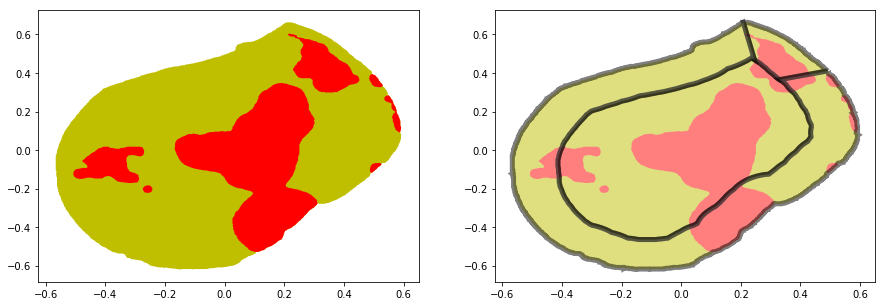

In [28]:
pZones(standPet, spotz, center, edge, throat)

We see that the throat delineation fails. That was with the default simp=0.5 for polygon simplification. Sometimes we can improve things a bit with a harder simplification:

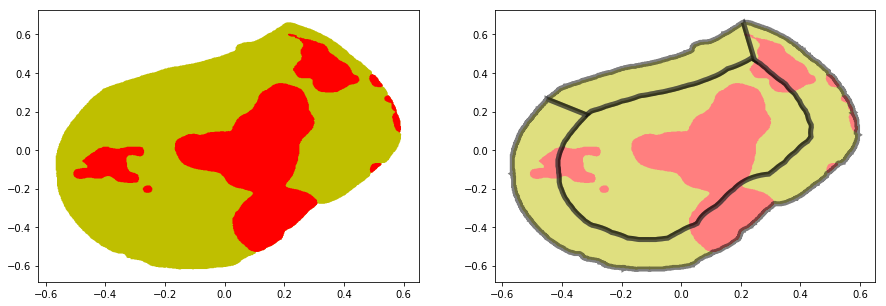

In [31]:
center, edge, throat = findZones(standPet, percent=0.5, simp=0.1)
pZones(standPet, spotz, center, edge, throat)

That worked. The defult settings sometimes work, sometimes not. But in general the throat zones are again a major problem, manual correction or some badass machine learning are the only way out. We will use manual correction, below. 

<h5><a id="applyDigZone">Applying our digitizing and Zone-calling to all files</a></h5>

To use these functions across all of our flower petals, we have these functions in a module, with a \_\_main\_\_ script for applying this. It's in the [github repo](https://github.com/danchurch/mimulusSpeckling/blob/master/make_polygons/get_pols.py), and is used on the command line like this:

So we can run this script on one of our black-and-white CSVs that we got from doug's pipeline [(above)](#dougOut). It works on a folder that contains the black-n-white csvs of petals and polygons, named according to Doug's original filename protocol:

`get_pols.py [folder with raster CSVs] [size of center polygon as percentage of petal] [destination folder]` 

A bash script for applying the petal/spot digitizing and zone-calling to all of the jpgs that I have from Melia and Doug:

In [ ]:
#!/usr/bin/env bash

getSpots='/Users/danthomas/Documents/speckling/make_polygons/get_spots.py'
getZones='/Users/danthomas/Documents/speckling/make_polygons/get_zones.py'
wd='/Users/danthomas/Documents/speckling/make_polygons/polygons'

cd $wd

for i in *; do
    echo $i 
    cd $i 
    for j in *; do
        fullN=$PWD/$j
        $getSpots $fullN $fullN
        find $fullN -name "*.geojson" -exec $getZones {} 0.5 \;
    done
    cd ../
done


<h3><a id="geoJFree">Side note: Geojson files equal freedom</a></h3>

The result of this pipeline are [geojson](http://geojson.org/) files. They should be viewable and editable in many types of outside software, such as GIS software like ARCGIS or QGIS: 

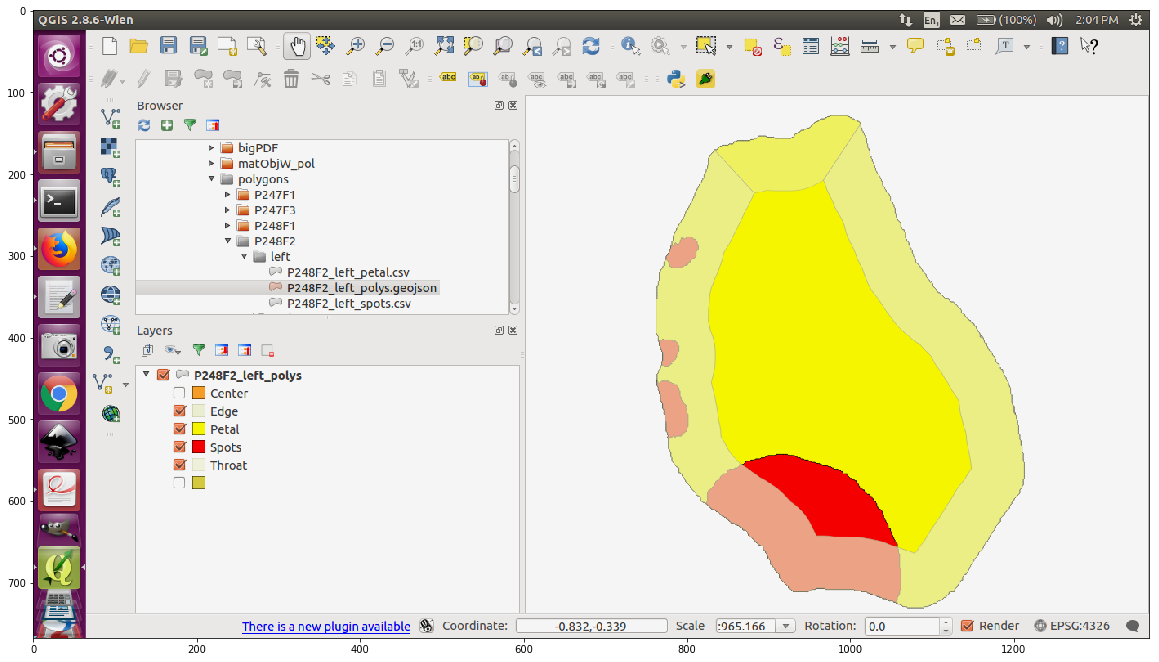

In [33]:
plt.rcParams['figure.figsize'] = [20, 20]
img=mpimg.imread('qGISscreenshot.png')
plt.imshow(img)

<h3><a id="manCor">Manual correction of spots and zones</a></h3>

We seen that our automated phenotyping creates lots of errors. So we wrote two simple programs for manually correcting our two most common errors: (1) merging of spots in our map that were separate on the original flower petal, and (2) misidentification of throat zones.

<h5><a id="breakSpot">Breaking spots</a></h5>

Our program for reducing error from (1) is called "[breakSpots.py](https://github.com/danchurch/mimulusSpeckling/blob/master/make_polygons/breakSpots.py)." Real python programmers will gag at this code, it is a spaghetti mess. For the moment, it works, and it will probably continue to work until someone else tries to use it. Syntax is:

`breakSpots.py [geojson] [--outFileName] [--jpeg]`

To use it, create a flat working directory of all the petals images, and loop the program through all of these files.

In [ ]:
## in the shell
## alias for program:
breakSpots='/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/breakSpots.py'
## original images:
dougRaster='/home/daniel/Documents/cooley_lab/mimulusSpeckling/dougRaster/Rotated_and_Cropped'
## geojson working directory
geojF='/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/geojsons'

cd $geojF

for i in *geojson; do
    ii=$geojF"/"$i
    j=${i%%_*}.JPG
    jj=$dougRaster"/"$j
    k=${i/.geojson/_spots_edited.geojson}
    kk=$geojF"/"$k
    echo $ii
    #echo $jj
    #echo $kk
    $breakSpots $ii -o $kk -j $jj
done

This calls the program for each geojson in the folder. With it, you draw polygons that bite out parts of spots and convert to petal background, or divide spots:

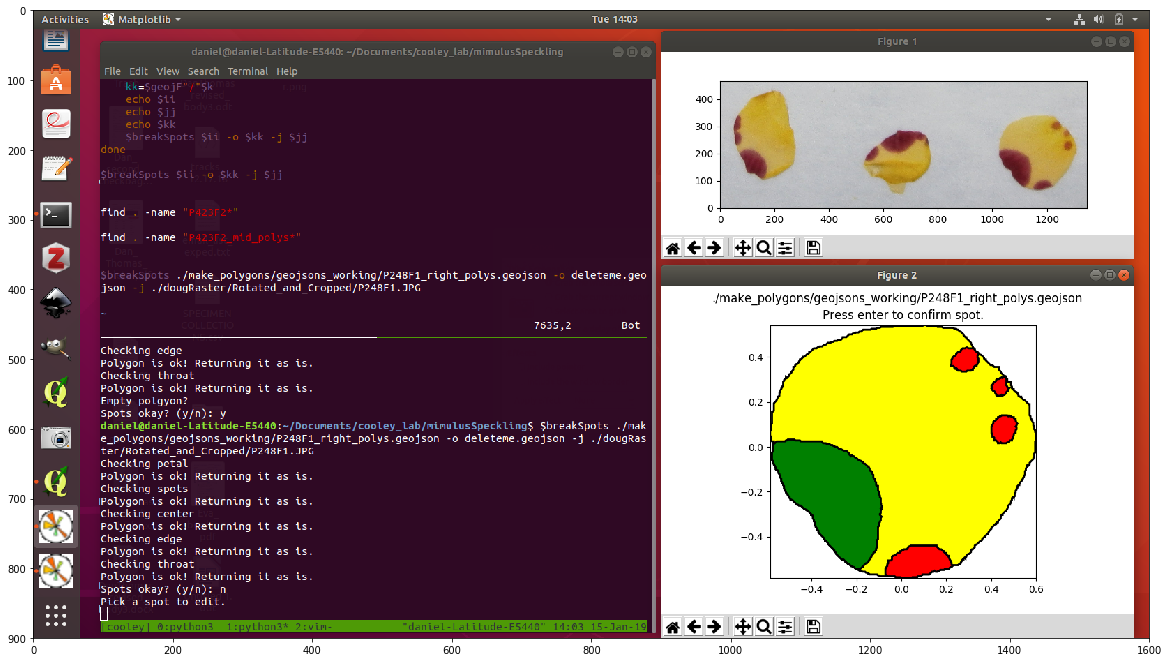

In [35]:
plt.rcParams['figure.figsize'] = [20, 20]
img=mpimg.imread('/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/spotBreaker.png')
plt.imshow(img)

<h5><a id="manZone">Manual correction of zones</a></h5>

We've coded a similar program for adjusting the zones. Use it in a similar way:

`manZoneCaller.py [geojson] [centerSize] [-o outfilename]`

"centerSize" = give the proportion of the middle of the flower you would like to call Center Zone, from 0.01 to 0.99. Best to make a flat directory of geojsons you would like to edit, and sic the program on them:

In [ ]:
for i in *; do
    echo $i
    $wd/manZoneCaller.py $i 0.5 --out ${i/.geojson/_mod.geojson}
    echo ${i/.geojson/_mod.geojson}
done

You can opt to try an automated zone-call with another simplification level, which can sometimes fix problems with throat zones, and/or draw your own corners. To do this, draw a polygon that incorporates all the area of the petal margin that you would like to be included in the throat region. It's okay to go outside the margin, the excess will be removed:

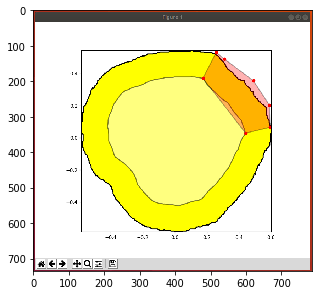

In [38]:
plt.rcParams['figure.figsize'] = [5, 5]
img=mpimg.imread('/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/manually_draw_throat.png')
plt.imshow(img)

Which gives us a new zone:

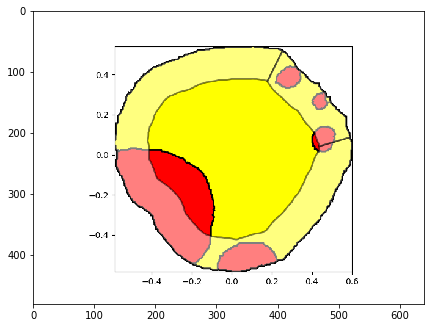

In [40]:
plt.rcParams['figure.figsize'] = [7, 7]
img=mpimg.imread('/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/manually_draw_throat2.png')
plt.imshow(img)

At this point our petal "maps" are somewhat-well curated, including by-eye sanity checks for automated petal/spot outlines and zones. So onto data collection from our maps.

<h1><a id="zones">Measuring raw data</a></h1>

<h2><a id="NutsNBolts">Some nuts and bolts - how are traits measured</a></h2>

Another module, "[flowerPetal](https://github.com/danchurch/mimulusSpeckling/blob/master/make_polygons/FlowerPetal.py)" handles measurement of the automated phenotyping. This module defines a custom python object class, "FlowerPetal".

In [2]:
## get a flower. Path will change. 
geojsonName = "/home/daniel/Documents/cooley_lab/mimulusSpeckling/\
make_polygons/polygons/P297F2/right/P297F2_right_polys.geojson"

In [3]:
geojsonName

'/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/polygons/P297F2/right/P297F2_right_polys.geojson'

In [4]:
flP = FlowerPetal()
flP.flowerName = 'P297F2'
flP.petalName = 'right'

If you give it a geojson of petals as above, it has methods to generate data about the petal from this:

In [5]:
## assign the geojson filename:
flP.geojson = geojsonName
## read the geojson, turn it into Shapely polygons 
flP.parseGeoJson()

In [6]:
## check for errors, try to clean them up:
flP.cleanFlowerPetal()

Checking petal
Polygon is ok! Returning it as is.
Checking spots
Polygon is ok! Returning it as is.
Checking center
Polygon is ok! Returning it as is.
Checking edge
Polygon is ok! Returning it as is.
Checking throat
Polygon is ok! Returning it as is.


In [7]:
## run all the measurements and fill in flower attributes with this info
flP.fillColumns()

The petal looks like this:

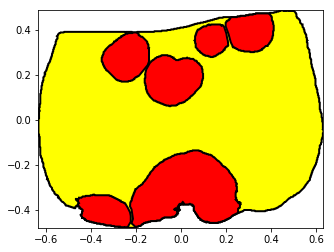

In [8]:
geojsonIO.plotOne(flP.petal); geojsonIO.addOne(flP.spots)

This petal has the following measurements ("traits"):

In [9]:
vars(flP)

{'plantName': None,
 'flowerName': 'P297F2',
 'petalName': 'right',
 'geojson': '/home/daniel/Documents/cooley_lab/mimulusSpeckling/make_polygons/polygons/P297F2/right/P297F2_right_polys.geojson',
 'petal': <shapely.geometry.polygon.Polygon at 0x7f96f0d4fd30>,
 'spots': <shapely.geometry.multipolygon.MultiPolygon at 0x7f96f0d4fcf8>,
 'center': <shapely.geometry.polygon.Polygon at 0x7f96f0d4fdd8>,
 'edge': <shapely.geometry.polygon.Polygon at 0x7f96f0d4fe10>,
 'throat': <shapely.geometry.polygon.Polygon at 0x7f96f0d4fe48>,
 'biggestSpotArea': 0.11177826873338739,
 'smallestSpotArea': 0.016721179916812177,
 'avgSpotSize': 0.043707264626960035,
 'medSpotSize': 0.031442029551284681,
 'nuSpots': 6,
 'nuSpotsContainedInCenter': 0,
 'nuSpotsTouchCenter': 5,
 'nuSpotsMostlyInCenter': 1,
 'nuSpotCentroidsInCenter': 1,
 'avgDist2CenterAllSpots': 0.37681071000591493,
 'avgDist2CenterCenterSpots': 0.17899763180246953,
 'propSpotsInCenter': 0.3202816260213142,
 'centerCoveredbySpots': 0.16814771514

So what are all these numbers?...
***

<h2><a id="TraitOverview">Traits overview</a></h2>

[<h3>General polygon:</h3>](#GP)

explanation | name of trait in code/data
------------|---------------------------
Biggest spot | [biggestSpotArea](#biggestSpotArea)
Smallest spot (is this useful at all?) | [smallestSpotArea](#smallestSpotArea)
Avg size | [avgSpotsize](#avgSpotsize)
Median size | [medSpotsize](#medSpotsize)
Number of spots | [nuSpots](#nuSpots)

[<h3>Centeredness:</h3>](#centerStats)

explanation | name of trait in code/data
------------|---------------------------
Number of spots entirely contained in center zone | [nuSpotsContainedInCenter](#nuSpotsContainedInCenter)
Number of spots touching center zone | [nuSpotsTouchCenter](#nuSpotsTouchCenter)
Number of spots mostly in center zone | [nuSpotsMostlyInCenter](#nuSpotsMostlyInCenter)
Number of spot centroids in center zone |  [nuSpotCentroidsInCenter](#nuSpotCentroidsInCenter)
avg spot centroid distance to center of all spots | [avgDist2CenterAllSpots](#avgDist2CenterAllSpots)
avg spot centroid distance to center of spots in center zone (excludes edge spots) | [avgDist2CenterCenterSpots](#avgDist2CenterCenterSpots)
Percent of total spot area in center | [propSpotsInCenter](#propSpotsInCenter)
Percent of center zone covered by spots | [centerCoveredbySpots](#centerCoveredbySpots)
Spot on centroid | [spotOnCentroid](#spotOnCentroid)

[<h3>Edgeness:</h3>](#edgeStats)

explanation | name of trait in code/data
------------|---------------------------
Number of spots entirely contained in edge zone | [nuSpotsContainedInEdge](#nuSpotsContainedInEdge)
Number of spots touching edge zone in some way | [nuSpotsTouchEdge](#nuSpotsTouchEdge)
Percent of total spot area in edge | [propSpotsInEdge](#propSpotsInEdge)
Number of spots mostly in edge zone (>Percent of) | [nuSpotsMostlyInEdge](#nuSpotsMostlyInEdge)
Percent of edge zone covered | [edgeCoveredbySpots](#edgeCoveredbySpots)
Number of spots touching actual edge (not zone)  | [nuSpotsTouchActualEdge](#nuSpotsTouchActualEdge)
Percent of length of real petal edge (not zone) covered | [realEdgeSpotted](#realEdgeSpotted)
avg dist of outline of spots to edge | [avgDistSpotEdge2Edge](#avgDistSpotEdge2Edge)
avg dist of centroid of spots to edge | [avgDistSpotCentroid2Edge](#avgDistSpotCentroid2Edge)

These last two exclude spots that contact the basal cut on the petal, if possible and measure the distance to the actual edge of the petal, not the zone.

[<h3>Throat:</h3>](#throatStats)

explanation | name of trait in code/data
------------|---------------------------
Percent of throat zone covered | [throatCoveredbySpots](#throatCoveredbySpots)
Percent of total spot area in throat | [propSpotsInthroat](#propSpotsInthroat)
Number of spots touching throat zone | [nuSpotsTouchThroat](#nuSpotsTouchThroat)
Number of spots mostly in throat zone | [nuSpotsMostlyInThroat](#nuSpotsMostlyInThroat)
Number of spots touching actual cut/base | [nuSpotsTouchCut](#nuSpotsTouchCut)

[<h3>Regions of petal, by distal/proximal half, or quadrant.</h3>](#regions)

This is a pretty crude division of the petals into quadrants. The quadrants of the petal are designated based on the centroid and the bounding box sides as othogonal bases. The quadrants are not necesarily equal in size. Probably very rarely, actually.

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in proximal half (quadrants I and II) | [nuProxSpots](#nuProxSpots)
Percent of total spot area in proximal half (quadrants I and II) | [propSpotsInProx](#propSpotsInProx)
Percent of proximal half covered by spots (quadrants I and II) | [proxCoveredbySpots](#proxCoveredbySpots)

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in Distal half (quadrants III and IV) | [nuDistSpots](#nuDistSpots)
Percent of total spot area in Distal half (quadrants III and IV) | [propSpotsInDist](#propSpotsInDist)
Percent of Distal half covered by spots (quadrants III and IV) | [distCoveredbySpots](#distCoveredbySpots)

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in quadrant I | [nuQuadISpots](#nuQuadSpots)
Percent of total spot area in quadrant I | [propSpotsInQuadI](#propSpotsInQuad)
Percent of quadrant I covered by spots | [quadICoveredbySpots](#quadCoveredbySpots)

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in quadrant II | [nuQuadIISpots](#nuQuadSpots)
Percent of total spot area in quadrant II | [propSpotsInQuadII](#propSpotsInQuad)
Percent of quadrant II covered by spots | [quadIICoveredbySpots](#quadCoveredbySpots)

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in quadrant III | [nuQuadIIISpots](#nuQuadSpots)
Percent of total spot area in quadrant III | [quadIIISpotsInQuadIII](#propSpotsInQuad)
Percent of quadrant III covered by spots | [quadIIICoveredbySpots](#quadCoveredbySpots)

explanation | name of trait in code/data
------------|---------------------------
Spots with centroids in quadrant IV | [nuQuadIVSpots](#nuQuadSpots)
Percent of total spot area in quadrant IV | [propSpotsInQuadIV](#propSpotsInQuad)
Percent of quadrant IV covered by spots | [quadIVCoveredbySpots](#quadCoveredbySpots)


<h3><a id='GP'>General polygon measurements:</a></h3>

These are pretty much self-explanatory. 

*** 
<a id='biggestSpotArea'>biggestSpotArea</a>

We take the area of largest spot polygon detected:

`biggestSpotArea = max([ i.area for i in self.spots ])`

In [87]:
flP.biggestSpotArea

0.11177826873338739

***
<a id='smallestSpotArea'>smallestSpotArea</a>

We take the area of smallest spot polygon detected. Seems probably useless, but it's easy to do:

`smallestSpotArea = min([ i.area for i in self.spots ])`

In [88]:
flP.smallestSpotArea

0.016721179916812177

***
<a id='avgSpotsize'>avgSpotsize</a>

We take the mean area of all spot polygons detected:

`avgSpotSize = mean([ i.area for i in self.spots ])`

In [89]:
flP.avgSpotSize

0.043707264626960035

***
<a id='medSpotsize'>medSpotsize</a>

We take the median value of all spot polygon areas detected:

`medSpotSize = np.median([ i.area for i in self.spots ])`

In [90]:
flP.medSpotSize

0.031442029551284681

***
<a id='nuSpots'>nuSpots</a>

This is the total number of distinct spots detected:

` nuSpots = len([ i.area for i in self.spots ])`

In [91]:
flP.nuSpots

6

[back to Traits overview](#TraitOverview)

<h3><a id='centerStats'>Centeredness:</a></h3>

In our digitizing pipeline we define a center zone that occupies the center 50% of the petal (translucent white zone) and a centroid of the petal that we consider the true center of the petal (blue plus sign): 

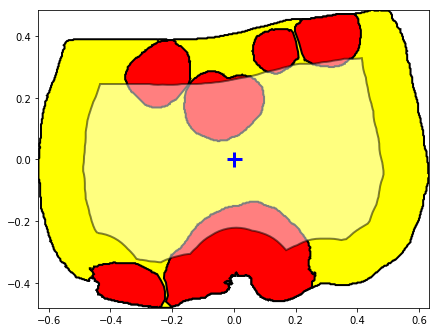

In [84]:
geojsonIO.plotOne(flP.petal); geojsonIO.addOne(flP.spots)
geojsonIO.addOne(flP.center, col='white', a=0.5)
plt.plot(flP.petal.centroid.x,flP.petal.centroid.y, 'b+', markersize=15, mew = 3)

***
<a id='nuSpotsContainedInCenter'>nuSpotsContainedInCenter</a>

This reports the number of spots contained entirely within the center zone, with no part of any of the candidate spots containing pixels outside of the center zone. This is a picky statistic, in this example petal no spots meet the criteria. 

`nuSpotsContainedInCenter = sum([ i.within(self.center) for i in self.spots ])`


In [86]:
flP.nuSpotsContainedInCenter

0

***
<a id='nuSpotsTouchCenter'>nuSpotsTouchCenter</a>

Reports the number of spot polygons that have any contact at all with the center zone. This is the least picky center statistic.

`nuSpotsTouchCenter = sum([ i.intersects(self.center) for i in self.spots ])`

In [92]:
flP.nuSpotsTouchCenter

5

***
<a id='nuSpotsMostlyInCenter'>nuSpotsMostlyInCenter</a>

This reports the number of spot polygons that have at least 50% of their area in the center zone:

`spotsMostlyInCenter = [ i for i in self.spots if (i.intersection(self.center).area / i.area > 0.5) ]`

`nuSpotsMostlyInCenter = len(spotsMostlyInCenter)`

In [93]:
flP.nuSpotsMostlyInCenter

1

<a id='nuSpotCentroidsInCenter'>nuSpotCentroidsInCenter</a>

In addition the general petal centroid, the spot polygons each have their own centroid. This statistic reports if this centroid is within the center zone.

`nuSpotCentroidsInCenter = sum([ i.centroid.intersects(self.center) for i in self.spots ] )`

In [95]:
flP.nuSpotCentroidsInCenter

1

<a id='avgDist2CenterAllSpots'>avgDist2CenterAllSpots</a>

This calculates the average distance between centroids of our spots to our petal centroid. This includes all of our spots, whereas the next statistic [avgDist2CenterCenterSpots](#avgDist2CenterCenterSpots) excludes spots not in the center zone. 

`avgDist2CenterAllSpots = mean([ i.centroid.distance(self.center.centroid) for i in self.spots ])`

In [96]:
flP.avgDist2CenterAllSpots

0.37681071000591493

***
<a id='avgDist2CenterCenterSpots'>avgDist2CenterCenterSpots</a>

This is the same as [avgDist2CenterAllSpots](#avgDist2CenterAllSpots), but only considers spots within the center zone. This was done to make possible the search for highly centered petal spots even when numerous spots exist on the edge of a petal.

`spotsMostlyInCenter = [ i for i in self.spots if (i.intersection(self.center).area / i.area > 0.5) ]`
`avgDist2CenterCenterSpots = mean([ i.centroid.distance(self.center.centroid) for i in spotsMostlyInCenter ])`

In [97]:
flP.avgDist2CenterCenterSpots

0.17899763180246953

***
<a id='propSpotsInCenter'>propSpotsInCenter</a>

This reports the percentage of total spotted area to be found in the center zone. This is meant to be more robust than simple counts of polygons, against merging errors in the spots. This should be equivalent to asking how many of our red pixels are found in the center zone of the petal. 

`partSpotsInCenter = [ i.intersection(self.center) for i in self.spots if i.intersects(self.center) ]`

`propSpotsInCenter = partSpotsInCenter.area / self.spots.area`

In [99]:
flP.propSpotsInCenter

0.3202816260213142

***
<a id='centerCoveredbySpots'>centerCoveredbySpots</a>

This is similar to [propSpotsInCenter](#propSpotsInCenter), but reports the percentage of the center zone occupied by red pixels.

`partSpotsInCenter = [ i.intersection(self.center) for i in self.spots if i.intersects(self.center) ]`

`centerCoveredbySpots = partSpotsInCenter.area / self.center.area`

In [100]:
flP.centerCoveredbySpots

0.1681477151460129

***
<a id='spotOnCentroid'>spotOnCentroid</a>

This simply reports whether any spot polygons are sitting on our petal centroid. True/False.

`spotOnCentroid = any([ i.intersects(self.petal.centroid) for i in self.spots ])`

In [102]:
flP.spotOnCentroid

False

[back to Traits overview](#TraitOverview)

<h3><a id='edgeStats'>Edgeness:</a></h3>

In our digitizing pipeline we define an center zone that occupies the center 50% of the petal. The remaining inner margin that contains the other 50% is then divided into an outer "edge" zone that buffers the natural edge of the petal, and an inner "throat" zone, that buffers the line of separation ("cut") of the petal from its flower. 

Here the edge is the translucent white zone: 

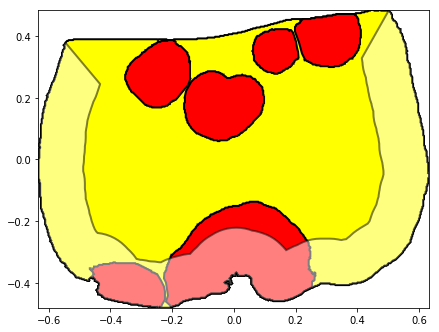

In [104]:
geojsonIO.plotOne(flP.petal); geojsonIO.addOne(flP.spots)
geojsonIO.addOne(flP.edge, col='white', a=0.5)

***
<a id='nuSpotsContainedInEdge'>nuSpotsContainedInEdge</a>

Number of spots entirely within the edge zone. A picky statistic, very sensitive to spot-merging.

`nuSpotsContainedInEdge = sum([ i.within(self.edge) for i in self.spots ])`

In [107]:
flP.nuSpotsContainedInEdge

1

***
<a id='nuSpotsTouchEdge'>nuSpotsTouchEdge</a>

Number of spots that have any part of their area in the edge zone.

`nuSpotsTouchEdge = sum([ i.intersects(self.edge) for i in self.spots ]`

In [108]:
flP.nuSpotsTouchEdge

2

***
<a id='propSpotsInEdge'>propSpotsInEdge</a>

Proportion of the total spotted (red) area of the petal that's in the edge zone. Code note shown, it's complicated, so see the FlowerPetal.py source code if you're curious.

In [111]:
flP.propSpotsInEdge

0.408151835595078

***
<a id='nuSpotsMostlyInEdge'>nuSpotsMostlyInEdge</a>

Number of spots that have 50% or more area within the edge zone.

`nuSpotsMostlyInEdge = len([ i for i in self.spots if (i.intersection(self.edge).area / i.area > 0.5) ])`

In [112]:
flP.nuSpotsMostlyInEdge

2

***
<a id='edgeCoveredbySpots'>edgeCoveredbySpots</a>

The proportion of the edge zone that is spotted (red). 

` partSpotsInEdge = [ i.intersection(self.edge) for i in self.spots if i.intersects(self.edge) ]
edgeCoveredbySpots = partSpotsInEdge.area / self.edge.area `


In [10]:
flP.edgeCoveredbySpots

0.29705388680544165

***
<a id='nuSpotsTouchActualEdge'>nuSpotsTouchActualEdge</a>

The number of spots that run to the physical edge ("rim") of the petal. This rim does not include the throat.

`nuSpotsTouchActualEdge = sum([ i.intersects(self.petal.exterior) for i in partSpotsInEdge ])`

In [115]:
flP.nuSpotsTouchActualEdge

2

***
<a id='realEdgeSpotted'>realEdgeSpotted</a>

The proportion of the length of physical edge of the petal ("rim") that is spotted (red). 

`spotEdges = sum([ i.intersection(self.petal.exterior).length for i in partSpotsInEdge ])
realEdgeSpotted = spotEdges / self.petal.exterior.length`


In [10]:
flP.realEdgeSpotted

0.22912916987734203

***
<a id='avgDistSpotEdge2Edge'>avgDistSpotEdge2Edge</a>

The average distance between the closest edge of all spots and the petal rim. 

`avgDistSpotEdge2Edge = mean([ petalRim.distance(i) for i in self.spots ])`

In [13]:
flP.avgDistSpotEdge2Edge

0.17621697063871114

***
<a id='avgDistSpotCentroid2Edge'>avgDistSpotCentroid2Edge</a>

The average distance between all spot centroids and the petal rim. 
  
`avgDistSpotCentroid2Edge = mean([ petalRim.distance(i.centroid) for i in self.spots ])`

In [14]:
flP.avgDistSpotCentroid2Edge

0.26412825783179705

[back to Traits overview](#TraitOverview)

<h3><a id="throatStats">Throat:</a></h3>

These are measurements pertaining to spots that interact with the basal zone of a petal, closest to where it was separated from the rest of the flower. The throat is the translucent white zone in the map:

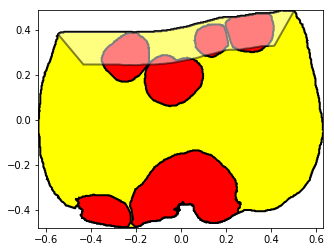

In [15]:
geojsonIO.plotOne(flP.petal); geojsonIO.addOne(flP.spots)
geojsonIO.addOne(flP.throat, col='white', a=0.5)

***
<a id='throatCoveredbySpots'>throatCoveredbySpots</a>

Proportion of the throat area that is spotted (red).  
<br>
`
 partSpotsInThroat = [ i.intersection(self.throat) for i in self.spots if i.intersects(self.throat) ]
throatCoveredbySpots = partSpotsInThroat.area / self.throat.area
`

In [17]:
flP.throatCoveredbySpots

0.5080893047095963

***
<a id='propSpotsInthroat'>propSpotsInthroat</a>  
<br>
Proportion of the total spotted (red) area of petal that is within the throat.  
<br>
`
propSpotsInThroat = partSpotsInThroat.area / self.spots.area
`

In [19]:
flP.propSpotsInThroat

0.2715665383836074

***
<a id='nuSpotsTouchThroat'>nuSpotsTouchThroat</a>

The number of spots that touch the throat zone in any way. 

`
nuSpotsTouchThroat = sum([ i.intersects(self.throat) for i in self.spots ])
`

In [20]:
flP.nuSpotsTouchThroat

4

***
<a id='nuSpotsMostlyInThroat'>nuSpotsMostlyInThroat</a>  

Number of spots with more than 50% of their area in the throat zone.  
<br>
`
nuSpotsMostlyInThroat = len([ i for i in self.spots if (i.intersection(self.throat).area / i.area > 0.5) ])
`

In [21]:
flP.nuSpotsMostlyInThroat

3

***
<a id='nuSpotsTouchCut'>nuSpotsTouchCut</a>

Number of spots that touch the basal cut of the petal. 

`
nuSpotsTouchCut = len([ i for i in partSpotsInThroat if i.intersects(self.petal.exterior) ])
`


In [24]:
flP.nuSpotsTouchCut

2

[back to Traits overview](#TraitOverview)

<a id="regions"><h3>Regions of petal, by distal/proximal half, or quadrant:</h3></a>

<h4>Spots in proximal half</h4>

The translucent-shaded half of the petal is examined.

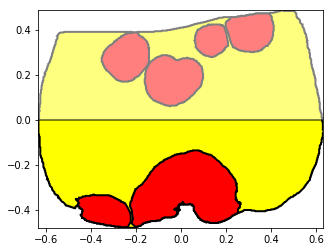

In [26]:
geojsonIO.plotOne(flP.petal); geojsonIO.addOne(flP.spots)
proxBox=sg.box(-1,0,1,1)
geojsonIO.addOne(proxBox, col='white', a=0.5)

***
<a id='nuProxSpots'>nuProxSpots</a>

Number of spots that touch the proximal half of the petal.

`
nuProxSpots = sum([ i.intersects(petalProx) for i in self.spots ])
`

In [28]:
flP.nuProxSpots

4

***

<a id='propSpotsInProx'>propSpotsInProx</a>  

Percentage of total spot (red) area of petal that is found in the proximal half of petal.  
<br>
`
propSpotsInProx = spottedSurfaceProx.area / self.spots.area
`

In [30]:
flP.propSpotsInProx

0.47527832275487414

***
<a id='proxCoveredbySpots'>proxCoveredbySpots</a>  
<br>
Proportion of area of proximal half of petal covered by spots.  
<br>
`
proxCoveredbySpots = spottedSurfaceProx.area / petalProx.area
`

In [32]:
flP.proxCoveredbySpots

0.24963940866251919

[back to Traits overview](#TraitOverview)

<h4>Spots in distal half</h4>

The translucent-shaded half of the petal is examined.

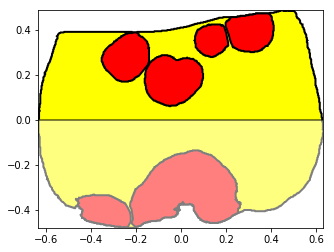

In [34]:
geojsonIO.plotOne(flP.petal); geojsonIO.addOne(flP.spots)
distBox=sg.box(-1,-1,1,0)
geojsonIO.addOne(distBox, col='white', a=0.5)

***
<a id='nuDistSpots'>nuDistSpots</a>

Number of spots that touch the distal half of the petal.

`
nuDistSpots = sum([ i.intersects(petalDist) for i in self.spots ])
`

In [36]:
flP.nuDistSpots

2

***
<a id='propSpotsInDist'>propSpotsInDist</a>

Percentage of total spot (red) area of petal that is found in the distal half of petal.  
<br>
`
propSpotsInDist = spottedSurfaceDist.area / self.spots.area
`

In [37]:
flP.propSpotsInDist

0.5247216772451259

***
<a id='distCoveredbySpots'>distCoveredbySpots</a>

Proportion of area of distal half of petal covered by spots.

`
distCoveredbySpots = spottedSurfaceDist.area / petalDist.area
`

In [38]:
flP.distCoveredbySpots

0.2748112629904847

[back to Traits overview](#TraitOverview)

<h2><a id="quadrants">Spots in quadrants</a></h2>

We also check the number of spots in a quadrant, the proportion of all spots found in each quadrant, and the percent coverage of a quadrant by spots.

This is a pretty crude division of the petals into quadrants. The quadrants of the petal are designated based on the centroid and the bounding box sides as othogonal bases. The quadrants are not necesarily equal in size. Probably very rarely, actually. 

This was also the beginning of analysis of symmetry, but a whole lot of work needs to happen there...

Text(0.25, -0.25, 'IV')

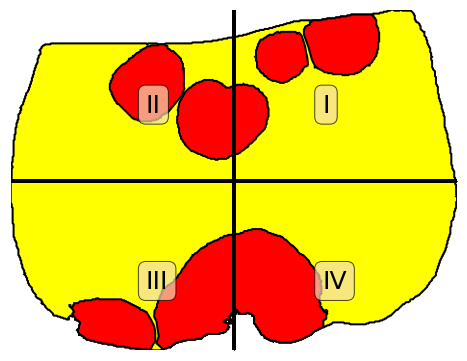

In [53]:
plt.rcParams['figure.figsize'] = [8, 8]
geojsonIO.plotOne(flP.petal); geojsonIO.addOne(flP.spots)
ax = plt.gca()
## moving spines we want
ax.spines['right'].set_position('zero')
ax.spines['bottom'].set_position('zero')
## removing the other spines
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
## removing the tick marks
ax.tick_params(bottom="off", right="off")
## get rid of the tick labels
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])
## increase line width
ax.axhline(linewidth=4, color = "k")
ax.axvline(linewidth=4, color = "k")
props = dict(boxstyle='round', facecolor='wheat', alpha=0.7)
ax.text(0.25, 0.25, "I", fontsize=25,
        verticalalignment='top', bbox=props)
ax.text(-0.25, 0.25, "II", fontsize=25,
        verticalalignment='top', bbox=props)
ax.text(-0.25, -0.25, "III", fontsize=25,
        verticalalignment='top', bbox=props)
ax.text(0.25, -0.25, "IV", fontsize=25,
        verticalalignment='top', bbox=props)

***
<a id='nuQuadSpots'>nuQuadSpots</a>  

Based on centroids of spots, how many spots are in a quadrant.  
<br>
`
nuQuadIspots = len([ i for i in self.spots if i.centroid.x > 0 and i.centroid.y > 0 ])
`

In [51]:
flP.nuQuadISpots

2

***
<a id='propSpotsInQuad'>propSpotsInQuad</a>  

Proportion of total spotted (red) area from petal is found in a quadrant.

`
propSpotsInQuadI = spottedSurfaceQuadI.area / self.spots.area
`

In [55]:
flP.propSpotsInQuadI

0.2318585808247405

<a id='quadCoveredbySpots'>quadCoveredbySpots</a>

Proportion of quadrant covered by spots (red).  
<br>
`
quadICoveredbySpots = spottedSurfaceQuadI.area / petalQuadI.area
`

In [57]:
flP.quadICoveredbySpots

0.2292068403072505

[back to Traits overview](#TraitOverview)

<h1><a id='updatePyPi'>Updating PyPi</a></h1>

It's important to keep PyPi updated with the latest consensus, "stable" version of this repo. As long as these tools are command-line based, this is the most painless way in which non-developer folks can stay up with the latest version of the package - they can just use `pip` to update whenever there is a bug fix or new feature.

As I'm handing this off to others for development, here is how I update our PyPi repository: